In [9]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.planar_clusters_gaussians.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *

import meshcat
import meshcat.geometry as meshcat_geom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

Meshcat url:  http://127.0.0.1:7003/static/


In [11]:
# Sample a dataset of scenes from the default grammar params.
# Draw a random sample from the grammar and visualize it.
# (Cache output.)
torch.random.manual_seed(2)
N_samples = 50
RESAMPLE = True
scenes_file = "sampled_scenes_%d.dat" % N_samples

ground_truth_grammar = SpatialSceneGrammar(
    root_node_type = Desk,
    root_node_tf = torch.eye(4)
)

if not os.path.exists(scenes_file) or RESAMPLE:
    samples = []
    for k in tqdm(range(N_samples)):
        tree = ground_truth_grammar.sample_tree(detach=True)
        observed_nodes = tree.get_observed_nodes()
        samples.append((tree, observed_nodes))

    print("Saving...")
    with open(scenes_file, "wb") as f:
        pickle.dump(samples, f)

print("Loading...")
with open(scenes_file, "rb") as f:
    samples = pickle.load(f)
print("Loaded %d scenes." % len(samples))
observed_node_sets = [x[1] for x in samples]

draw_scene_tree_contents_meshcat(samples[0][0], zmq_url=vis.window.zmq_url, prefix="sample")


Saving...
Loading...
Loaded 50 scenes.


In [13]:
# Initialize a grammar with wide parameter guesses.
grammar = SpatialSceneGrammar(
    root_node_type = Desk,
    root_node_tf = torch.eye(4),
    sample_params_from_prior=True
)

def do_vis(tree):
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sampled_in_progress")

if 0:
    posterior_sample_sets = collect_posterior_sample_sets(grammar, observed_node_sets)
    for k, tree in enumerate(posterior_sample_sets[-1]):
        draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="guesses/%d" % k)

In [14]:
torch.save(grammar, "/tmp/test_saved_grammar.torch")
orig_grammar = torch.load("/tmp/test_saved_grammar.torch")

In [15]:
if 0:
    grammar = fit_grammar_params_to_sample_sets_with_uninformative_prior(grammar, posterior_sample_sets)
    print("**********************************\n"
          "**********  BEFORE ***************\n"
          "************************************")
    orig_grammar.print_params(node_names=["Desk"])
    print("**********************************\n"
          "**********  AFTER ***************\n"
          "************************************")
    grammar.print_params(node_names=["Desk"])
    print("**********************************\n"
          "**********  TRUTH ***************\n"
          "************************************")
    ground_truth_grammar.print_params(node_names=["Desk"])

In [16]:
state_dict_history = []
for iter_k in tqdm(range(20), desc="Major iteration"):
    state_dict_history.append(deepcopy(grammar.state_dict()))
    posterior_sample_sets = collect_posterior_sample_sets(grammar, observed_node_sets, num_workers=8, tqdm=tqdm)
    # Check out if it does good fitting on the sample set itself -- which it should!
    #posterior_sample_sets = [[x[0] for x in samples]]
    grammar = fit_grammar_params_to_sample_sets_with_uninformative_prior(grammar, posterior_sample_sets)
state_dict_history.append(deepcopy(grammar.state_dict()))

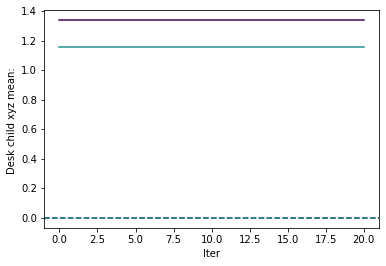

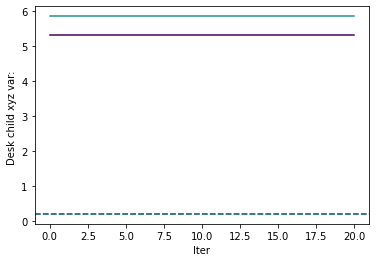

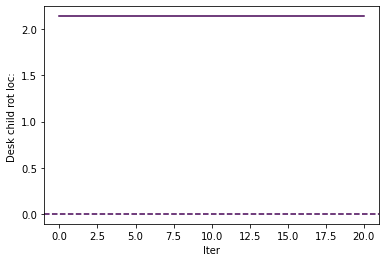

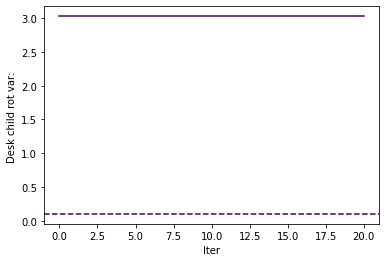

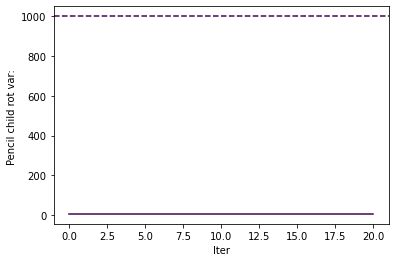

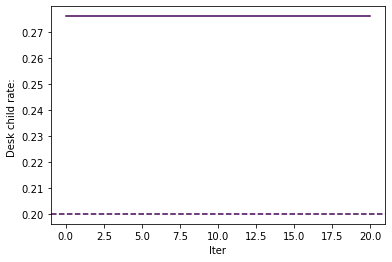

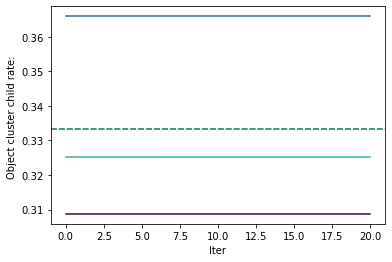

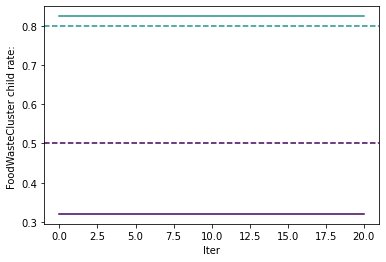

In [17]:
# Plot a couple of interesting parameters
param_getters_of_interest = {
    "Desk child xyz mean: ": lambda x: x.rule_params_by_node_type["Desk"][0][0]["mean"]().detach().numpy(),
    "Desk child xyz var: ": lambda x: x.rule_params_by_node_type["Desk"][0][0]["variance"]().detach().numpy(),
    "Desk child rot loc: ": lambda x: x.rule_params_by_node_type["Desk"][0][1]["loc"]().detach().numpy(),
    "Desk child rot var: ": lambda x: x.rule_params_by_node_type["Desk"][0][1]["concentration"]().detach().numpy(),
    "Pencil child rot var: ": lambda x: x.rule_params_by_node_type["PencilCluster"][0][1]["concentration"]().detach().numpy(),
    "Desk child rate: ": lambda x: x.params_by_node_type["Desk"]().detach().numpy(),
    "Object cluster child rate: ": lambda x: x.params_by_node_type["ObjectCluster"]().detach().numpy(),
    "FoodWasteCluster child rate: ": lambda x: x.params_by_node_type["FoodWasteCluster"]().detach().numpy(),
    
}

for key, getter in param_getters_of_interest.items():
    plt.figure()
    history = []
    for state_dict in state_dict_history:
        grammar.load_state_dict(state_dict)
        history.append(getter(grammar).copy().flatten())
    data = np.stack(history)

    gt_x = getter(ground_truth_grammar).flatten()
    cm = plt.get_cmap("viridis")
    N = len(gt_x)
    for k in range(N):
        color = cm(k / max(1, N))
        plt.plot(data[:, k], color=color)
        plt.axhline(gt_x[k], color=color, linestyle="--")
    plt.xlabel("Iter")
    plt.ylabel(key)
